# AI Final Project: Pneumonia Detection from Chest X-Rays

**Team Members:**
* 2010356 Fernando Patricio Gutiérrez González
* 2132103 Axel Muñoz Baca
* 2050354 Ulises Castillo Díaz
* 2055281 Pablo Daniel Contreras Obregón

**Objective:**
This project trains a **Convolutional Neural Network (CNN)** to classify chest X-ray images as either **'NORMAL'** or **'PNEUMONIA'**. The model is built using TensorFlow and Keras.

**Methodology:**
1.  **Dataset:** Uses the Kaggle "Chest X-Ray Images (Pneumonia)" dataset.
2.  **Data Loading:** Loads `train` and `test` sets, splitting the `train` data (80%) into a new training set and a validation set (20%) to ensure robust evaluation.
3.  **Model Architecture:** A sequential CNN model with 3 `Conv2D/MaxPooling2D` blocks, followed by a `Flatten` layer and `Dense` layers for classification.
4.  **Key Techniques:**
    * **Data Augmentation:** Applies random flips, rotations, and zooms to prevent overfitting.
    * **Class Imbalance:** Uses `class_weights` to give more importance to the minority 'NORMAL' class.
    * **Regularization:** Implements `Dropout` to reduce overfitting.
    * **Efficiency:** Uses `EarlyStopping` to halt training when validation loss stops improving, restoring the best model weights.

In [1]:
# Artificial Intelligence Final Project
"""
This is the main code for the training of a CNN based on X-ray chest scan (with pneumonia or healthy).
The work is purely academic and for learning purposes. It does not intend to replace any medical diagnosis.
This project is Open Source and can be found at the following repository:
Link: https://github.com/Patopro05/AI_FinalProject/edit/main
Team members:
2010356 Fernando Patricio Gutiérrez González
2132103 Axel Muñoz Baca
2050354 Ulises Castillo Díaz
2055281 Pablo Daniel Contreras Obregón
"""

# Importing libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
import zipfile

## Important: Kaggle API Setup

Mr. Dani, to run this notebook, you must provide your own Kaggle API key.
1.  Go to your Kaggle account, click on your profile, and go to "Settings".
2.  In the "API" section, click **"Create New Token"**. This will download a `kaggle.json` file.
3.  Run the cell below. It will ask you to upload a file.
4.  Upload the `kaggle.json` file you just downloaded.

The notebook will then be able to download the dataset.

In [2]:
# 1. Install the Kaggle API
!pip install kaggle

# 2. Upload your kaggle.json API token
from google.colab import files
print("Please upload your kaggle.json file:")
files.upload()

# 3. Configure the Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\nKaggle API configured successfully.")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

Kaggle API configured successfully.


In [3]:
print("Downloading the 'chest-xray-pneumonia' dataset from Kaggle...")
# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

print("Download complete. Unzipping files...")
# Unzip the file quietly (-q)
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('.') # Extracts to the current directory

print("Unzipping complete. Dataset is ready.")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:33<00:00, 141MB/s]
100% 2.29G/2.29G [00:33<00:00, 74.5MB/s]
Download complete. Unzipping files...
Unzipping complete. Dataset is ready.


In [4]:
# Dataset directory
# The zip file unzips into a folder named 'chest_xray' in the root '/content/' directory
BASE_DIR = 'chest_xray' # Corrected for Colab
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
# VAL_DIR is tiny and not useful, we will create our own split

# Parameters for dataset loading
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2 # We will take 20% of the training data for validation

In [5]:
print("Loading and preprocessing data...")

# Train dataset (80% of the original train folder)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    validation_split = VALIDATION_SPLIT,
    subset = 'training',
    seed = 123
)

# Validation dataset (20% of the original train folder)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, # We read from the same directory
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    validation_split = VALIDATION_SPLIT,
    subset = 'validation', # Note the subset 'validation'
    seed = 123
)

# Test dataset (from the original test folder)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

class_names = train_dataset.class_names
print(f"\nClasses found: {class_names}")

# Optimize all datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Datasets loaded and optimized.")

Loading and preprocessing data...
Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.

Classes found: ['NORMAL', 'PNEUMONIA']
Datasets loaded and optimized.


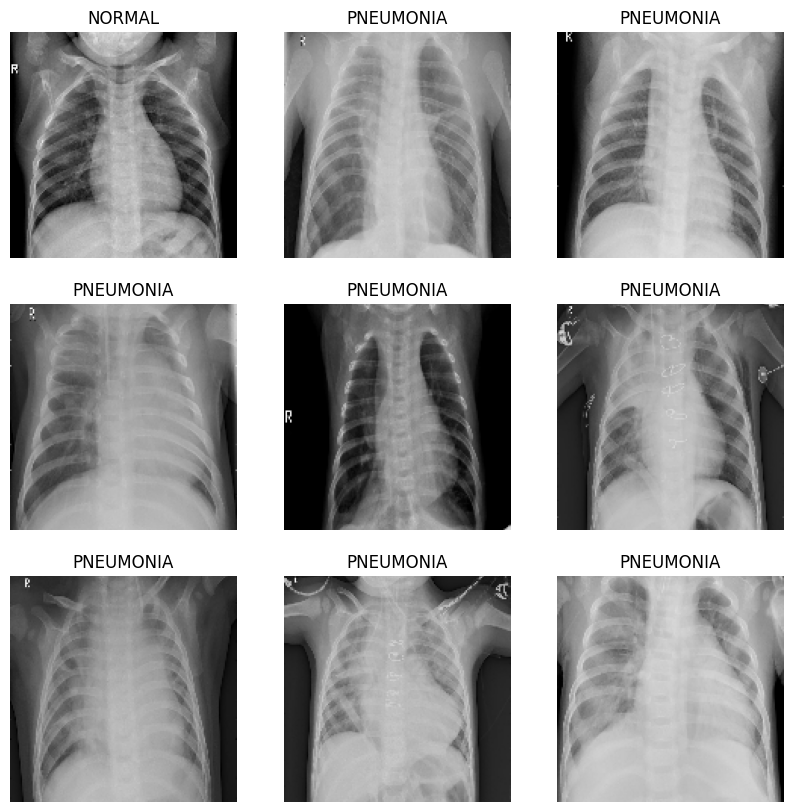

In [6]:
# Plotting dataset samples
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.show() # Correctly show the plot

In [7]:
# Data augmentation
data_augmentation = models.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ], name = "data_augmentation"
)

In [8]:
# The model
model = models.Sequential()
model.add(layers.Input(shape = (IMG_SIZE[0], IMG_SIZE[1], 3) ))
model.add(data_augmentation)
model.add(layers.Rescaling(1./255))

model.add(layers.Conv2D(32,(3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

# Print a summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compiling the model
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

# Weight calculation (based on our previous findings)
total_train_files = 4173 # 80% of 5216
weight_for_0 = (1 / 1073) * (total_train_files / 2.0) # NORMAL
weight_for_1 = (1 / 3100) * (total_train_files / 2.0) # PNEUMONIA
class_weights = {0: weight_for_0, 1: weight_for_1}

print(f"Class Weights: {class_weights}")

# Callbacks
early_stopping_cb = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

Class Weights: {0: 1.9445479962721341, 1: 0.6730645161290323}


In [10]:
# Train
print("Starting model training...")
history = model.fit(
    train_dataset,
    epochs = 20, # Max epochs
    validation_data = val_dataset,
    class_weight = class_weights,
    callbacks = [early_stopping_cb]
)
print("Training complete.")

Starting model training...
Epoch 1/20
  1/131 ━━━━━━━━━━━━━━━━━━━━ 14:36 7s/step - accuracy: 0.4375 - loss: 0.6106

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step - accuracy: 0.4375 - loss: 0.6106 - val_accuracy: 0.7766 - val_loss: 1.1587
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.8438 - loss: 1.2561 - val_accuracy: 0.7766 - val_loss: 0.5634
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.7812 - loss: 0.6525 - val_accuracy: 0.2234 - val_loss: 0.7524
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.2500 - loss: 0.6524 - val_accuracy: 0.2234 - val_loss: 0.7172
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 414ms/step - accuracy: 0.4062 - loss: 0.6147 - val_accuracy: 0.7824 - val_loss: 0.6783
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.5625 - loss: 0.5926 - val_accuracy: 0.7766 - val_loss: 0.6523
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.7500 - loss: 0.5842 - val_accuracy: 0.7766 - val_loss: 0.6124
Training complete.


In [11]:
# Model accuracy for testing
print("\nEvaluating model on the test dataset...")
test_loss, test_acc = model.evaluate(test_dataset)

print(f'\nFinal Test Accuracy: {test_acc * 100:.2f}%')
print(f'Final Test Loss: {test_loss:.4f}')


Evaluating model on the test dataset...
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 948ms/step - accuracy: 0.6282 - loss: 0.6711

Final Test Accuracy: 62.50%
Final Test Loss: 0.6729


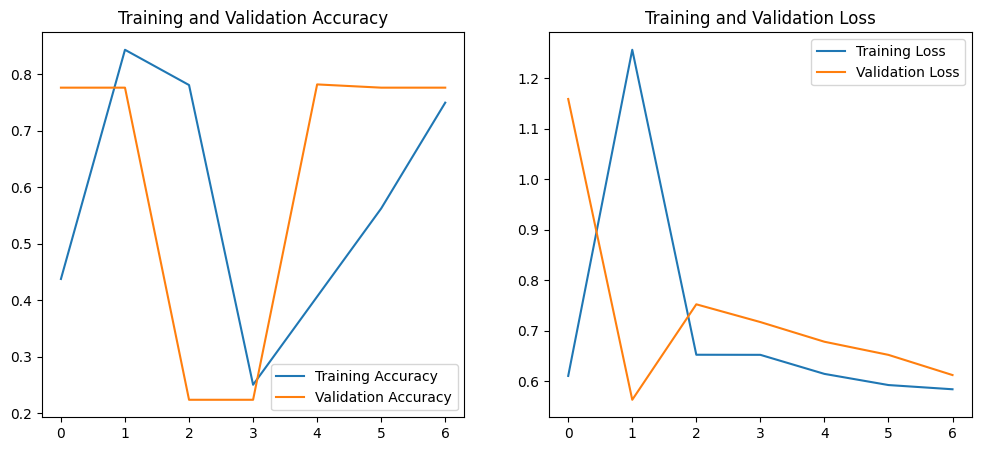

In [12]:
# Graphing plot for Training and Validation
epochs_ran = len(history.history['loss'])

plt.figure(figsize= (12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(epochs_ran), history.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(epochs_ran), history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs_ran), history.history['loss'], label = 'Training Loss')
plt.plot(range(epochs_ran), history.history['val_loss'], label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.show()